<a href="https://colab.research.google.com/github/melodymeow/Mortgage_Defaut_Analysis/blob/master/Melody_PYTH_225_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mortgage Delinquency Rate Analysis**

The goal of the project is to explore the analysis deliquency data and explore it's relationship with variables, such as HPI and unemployment rate.

Data:
There are three sets of data for the analysis:

1.   Quarterly delinquency data by asset type
2.   Monthly delinquency data by states (30-89 days and 90+)
3.   Quarterly HPI data
4.   Monthly unemployment data

Goal:

1.   clean up the data and combine different dataframe
2.   analyze relationships between dataset


6.adding function for multiple line graph

In [56]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import matplotlib.patches as mpatches

print('import successful')

import successful


# **Import Data**

In [0]:
#import deqlinquency data from federal reserve by quarter
url = 'https://www.federalreserve.gov/releases/chargeoff/delallsa.htm'
html = requests.get(url).content
delinquency_list = pd.read_html(html)
dq = delinquency_list[2]
dq.columns = ['Date','All Real Estate Loan','Residential','Commercial','Farmland','All Consumer','Credit Card','Other Consumer','Leases','C&I Loans','Agricultural Loans','Total Loans and Leases']
cols = dq.columns.drop('Date')
dq[cols] = dq[cols].apply(pd.to_numeric,errors = 'coerce')

#delinquency data by states and year from consumer bureau 
dqstate_30to89 = pd.read_csv('30-89daysDQ.csv')
dqstate_90plus = pd.read_csv('90daysDQ.csv')

#import HPI Data
hpi = pd.read_csv('HPI_AT_state.csv',header=None)
hpi.columns = ['States','Year','Quarter','HPI']
hpi['HPI'] = pd.to_numeric(hpi['HPI'],errors = 'coerce')

#unemployment data from department of bureau
unemployment = pd.read_excel('unemployment data.xlsx')
unemployment = unemployment.tail(12)
unemployment.columns = unemployment.iloc[0]
unemployment = unemployment[1:]
unemployment.set_index('Year',drop = True,inplace = True)


**Data Preview**

In [58]:
dq.head()

,Date,All Real Estate Loan,Residential,Commercial,Farmland,All Consumer,Credit Card,Other Consumer,Leases,C&I Loans,Agricultural Loans,Total Loans and Leases
0,2019:4,1.52,2.35,0.67,2.34,2.34,2.61,2.08,1.24,1.14,2.06,1.44
1,2019:3,1.59,2.46,0.68,2.25,2.32,2.58,2.06,1.16,1.13,1.91,1.46
2,2019:2,1.68,2.59,0.68,2.30,2.34,2.57,2.13,1.11,1.06,1.83,1.50
3,2019:1,1.74,2.69,0.69,2.24,2.34,2.58,2.12,1.18,1.13,1.71,1.53
4,2018:4,1.80,2.83,0.70,2.26,2.33,2.54,2.11,1.02,0.96,1.74,1.53


In [59]:
dqstate_30to89.head()

,RegionType,Name,FIPSCode,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,...,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,National,United States,-----,3.5,3.2,3.1,3.1,3.2,3.2,3.4,3.6,3.6,3.8,3.9,4.2,4.2,3.9,3.7,3.7,3.8,3.8,4.0,4.0,3.9,4.0,3.9,3.9,4.0,3.7,3.4,3.3,3.4,3.5,3.7,3.7,3.7,3.7,3.6,3.7,3.7,...,2.0,2.2,2.3,2.1,2.3,2.1,2.3,2.4,2.1,2.0,1.9,2.0,1.9,2.1,2.2,2.0,2.1,1.9,2.1,2.3,2.0,1.9,1.7,1.9,1.8,2.0,2.1,2.0,2.0,1.9,2.1,2.2,1.9,1.8,1.6,1.8,1.7,2.0,2.0,1.9
1,State,Alabama,'01',4.4,4.0,3.9,3.9,4.1,3.9,4.2,4.6,4.5,4.8,4.7,5.2,5.2,4.6,4.2,4.2,4.7,4.4,4.9,4.8,4.8,5.1,5.1,5.3,5.3,4.8,4.3,4.4,4.7,4.8,5.0,5.0,5.0,4.9,4.9,5.1,5.1,...,3.0,3.3,3.4,3.0,3.6,3.3,3.6,3.8,3.2,3.1,2.9,2.9,2.8,3.3,3.4,3.1,3.3,3.2,3.4,3.8,3.2,3.0,2.6,2.8,2.8,3.1,3.1,3.0,3.3,3.0,3.2,3.3,2.9,2.7,2.4,2.6,2.5,3.0,3.1,2.9
2,State,Alaska,'02',2.8,2.2,2.3,2.2,2.0,2.2,2.0,2.3,2.0,1.3,1.6,2.1,2.3,2.4,2.1,2.3,2.3,2.5,2.9,2.9,2.7,2.5,2.1,2.2,2.6,2.7,2.5,2.4,2.3,2.3,2.3,2.3,2.4,2.5,2.0,2.4,2.4,...,1.2,1.6,1.6,1.6,1.5,1.2,1.3,1.5,1.5,1.7,1.6,1.8,1.4,1.7,1.7,1.7,1.5,1.4,1.6,2.1,1.8,1.7,1.7,1.7,1.5,1.6,1.7,1.5,1.3,1.3,1.5,1.9,1.5,1.4,1.3,1.5,1.5,1.8,1.7,1.6
3,State,Arizona,'04',3.5,3.3,3.2,3.2,3.4,3.4,3.6,4.0,4.1,4.3,4.6,5.0,5.0,4.8,4.5,4.5,4.4,4.3,4.5,4.6,4.5,4.5,4.3,4.3,4.3,4.2,3.7,3.5,3.6,3.7,3.9,4.0,4.0,4.0,3.9,3.9,3.5,...,1.6,1.7,1.9,1.7,1.9,1.8,1.9,2.0,1.7,1.6,1.5,1.6,1.6,1.7,1.9,1.7,1.8,1.7,1.9,2.1,1.9,1.7,1.6,1.6,1.5,1.7,1.9,1.7,1.8,1.8,1.8,1.9,1.7,1.5,1.4,1.5,1.5,1.7,1.8,1.6
4,State,Arkansas,'05',4.0,3.5,3.2,3.1,3.4,3.5,3.5,3.8,3.9,4.1,4.1,4.3,4.5,4.1,3.5,3.6,3.7,3.7,4.0,4.0,4.2,4.3,4.3,4.4,4.6,4.2,3.6,3.6,3.9,4.0,4.2,4.2,4.2,4.6,4.4,4.3,4.5,...,2.5,2.7,2.9,2.8,3.1,2.8,2.9,3.0,2.7,2.6,2.4,2.6,2.6,2.7,2.8,2.6,3.0,2.9,3.2,3.5,2.9,2.6,2.4,2.5,2.4,2.6,2.6,2.7,3.0,2.7,3.1,3.0,2.4,2.3,2.1,2.4,2.4,2.5,2.4,2.2


In [60]:
hpi.head()

,States,Year,Quarter,HPI
0,AK,1975,1,63.76
1,AK,1975,2,65.15
2,AK,1975,3,69.84
3,AK,1975,4,69.31
4,AK,1976,1,73.25


In [61]:
unemployment.info()
unemployment.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 2010 to 2020
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Jan     11 non-null     object
 1   Feb     11 non-null     object
 2   Mar     11 non-null     object
 3   Apr     10 non-null     object
 4   May     10 non-null     object
 5   Jun     10 non-null     object
 6   Jul     10 non-null     object
 7   Aug     10 non-null     object
 8   Sep     10 non-null     object
 9   Oct     10 non-null     object
 10  Nov     10 non-null     object
 11  Dec     10 non-null     object
dtypes: object(12)
memory usage: 1.1+ KB


10,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2010,9.8,9.8,9.9,9.9,9.6,9.4,9.4,9.5,9.5,9.4,9.8,9.3
2011,9.1,9,9,9.1,9,9.1,9,9,9,8.8,8.6,8.5
2012,8.3,8.3,8.2,8.2,8.2,8.2,8.2,8.1,7.8,7.8,7.7,7.9


# **Function**

In [0]:
#date converter
def convert_to_last_day_of_quarter(val):
  year, quarter = val.split(':')
  year = int(year)
  quarter = int(quarter)
  year_dt = datetime(year, 1, 1)
  month = quarter * 3
  last_day = year_dt.replace(month=month) + pd.tseries.offsets.QuarterEnd()

  return last_day.to_pydatetime()

def convert_to_last_day_of_month(val):
  year,month = val.split('-')
  year = int(year)
  month = int(month)
  last_day = datetime(year,month,1) + pd.tseries.offsets.MonthEnd()
  return last_day.to_pydatetime()

In [0]:
# State abbrevation Function
def state_abbrev(states):
  us_state_abbrev = {
      'Alabama': 'AL',
      'Alaska': 'AK',
      'American Samoa': 'AS',
      'Arizona': 'AZ',
      'Arkansas': 'AR',
      'California': 'CA',
      'Colorado': 'CO',
      'Connecticut': 'CT',
      'Delaware': 'DE',
      'District of Columbia': 'DC',
      'Florida': 'FL',
      'Georgia': 'GA',
      'Guam': 'GU',
      'Hawaii': 'HI',
      'Idaho': 'ID',
      'Illinois': 'IL',
      'Indiana': 'IN',
      'Iowa': 'IA',
      'Kansas': 'KS',
      'Kentucky': 'KY',
      'Louisiana': 'LA',
      'Maine': 'ME',
      'Maryland': 'MD',
      'Massachusetts': 'MA',
      'Michigan': 'MI',
      'Minnesota': 'MN',
      'Mississippi': 'MS',
      'Missouri': 'MO',
      'Montana': 'MT',
      'Nebraska': 'NE',
      'Nevada': 'NV',
      'New Hampshire': 'NH',
      'New Jersey': 'NJ',
      'New Mexico': 'NM',
      'New York': 'NY',
      'North Carolina': 'NC',
      'North Dakota': 'ND',
      'Northern Mariana Islands':'MP',
      'Ohio': 'OH',
      'Oklahoma': 'OK',
      'Oregon': 'OR',
      'Pennsylvania': 'PA',
      'Puerto Rico': 'PR',
      'Rhode Island': 'RI',
      'South Carolina': 'SC',
      'South Dakota': 'SD',
      'Tennessee': 'TN',
      'Texas': 'TX',
      'Utah': 'UT',
      'Vermont': 'VT',
      'Virgin Islands': 'VI',
      'Virginia': 'VA',
      'Washington': 'WA',
      'West Virginia': 'WV',
      'Wisconsin': 'WI',
      'Wyoming': 'WY',
      'United States': 'US'}
  return us_state_abbrev.get(states,'Not Found')

# **Data Cleaning**

In [0]:
#clean up deqlinquency data: adding year and quarter, and move them to the front
#then drop Date column to index
dq[['year','quarter']] = dq['Date'].str.split(':',expand=True)
dq.year = dq.year.astype(int)
dq.quarter = 'Q' + dq.quarter
cols = dq.columns.tolist()
cols = cols[-2:] + cols[:-2]
dq = dq[cols]
dq['Date'] = dq['Date'].apply(convert_to_last_day_of_quarter)
dq.set_index('Date',drop = False, inplace = True)

In [0]:
#clean up dq by state data: 
#convert state to abbrevation
#covert data to numeric

dqstate_30to89['Name'] = dqstate_30to89['Name'].map(state_abbrev)
dqstate_30to89.rename(columns={'Name':'States'},inplace=True)
dqstate_30to89.set_index('States',drop=True,inplace=True)


In [0]:
#transpose dataframe
dqstate_30to89.drop(['RegionType','FIPSCode'],axis=1,inplace=True)
dqstate_30to89 = dqstate_30to89.transpose()


In [0]:
#convert obj to numeric in the dataframe
cols = dqstate_30to89.columns
dqstate_30to89[cols] = dqstate_30to89[cols].apply(pd.to_numeric,errors = 'coerce')
dqstate_30to89.reset_index(inplace=True)
dqstate_30to89['index'] = dqstate_30to89['index'].apply(convert_to_last_day_of_month)
dqstate_30to89.set_index('index',drop = True,inplace=True)


In [0]:
#clean up hpi data
hpi['Date'] = hpi[['Year','Quarter']].astype(str).apply(lambda x:':'.join(x),axis=1)
hpi['Date'] = hpi['Date'].apply(convert_to_last_day_of_quarter)


In [69]:
#convert the umemployment data to one single column

my_dict = {}
for i in range(0,11):
  year = int(unemployment.index[i])
  for j in range(0,12):
    month = int(j)+1
    key = datetime(year,month,1) + pd.tseries.offsets.MonthEnd()
    value = unemployment.iloc[i,j]
    my_dict[key] = value

new_unemployment = pd.DataFrame([my_dict]).transpose()
new_unemployment = new_unemployment.reset_index().rename(columns={"index":"Date",0:"unemployment"})
new_unemployment.info()                

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          132 non-null    datetime64[ns]
 1   unemployment  123 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 KB


In [70]:
new_unemployment.columns.to_list()

['Date', 'unemployment']

# **Data Visualization**

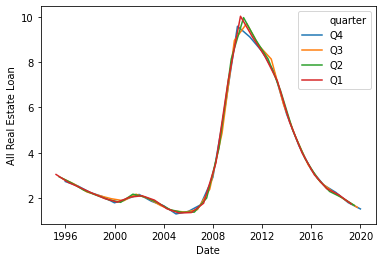

In [71]:
sns.lineplot('Date','All Real Estate Loan',data = dq.head(100),hue='quarter')

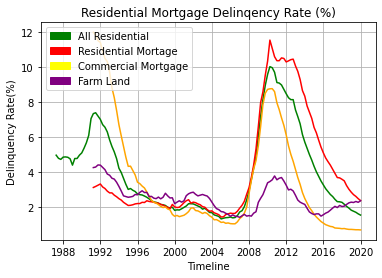

In [72]:
#line chart wiht multiple lines
x_lables = dq['Date']
y_dq_all = dq['All Real Estate Loan']
y_dq_resi = dq['Residential']
y_dq_comm = dq['Commercial']
y_dq_farm = dq['Farmland']

plt.plot(y_dq_all,color = 'green')
plt.plot(y_dq_resi,color = 'red')
plt.plot(y_dq_comm,color = 'orange')
plt.plot(y_dq_farm,color = 'purple')

plt.title('Residential Mortgage Delinqency Rate (%)')
plt.xlabel('Timeline')
plt.ylabel('Delinquency Rate(%)')

green_patch = mpatches.Patch(color='green',label='All Residential')
red_patch = mpatches.Patch(color='red',label='Residential Mortage')
orange_patch = mpatches.Patch(color='yellow',label = 'Commercial Mortgage')
purple_patch = mpatches.Patch(color='purple',label = 'Farm Land')
plt.legend(handles=[green_patch,red_patch,orange_patch,purple_patch])

plt.grid(True)
plt.show()


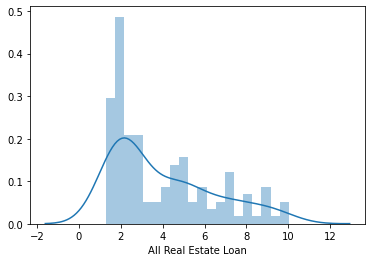

In [73]:
# distribution plot
sns.distplot(dq['All Real Estate Loan'],kde = True, bins = 20)

In [0]:
#building a function that combine delinquency, hpi and unemployment 

def get_state_dq (val):
  state = val
  hpi_data = hpi.loc[hpi['States']==state].loc[hpi['Year']>2008]
  hpi_dq = hpi_data.join(dqstate_30to89[state],on='Date')
  hpi_dq_unemployment = pd.merge(hpi_dq,new_unemployment,on='Date')
  ax = hpi_dq.plot('Date',state)
  plt.title('Delinquency Rate by State')
  g = hpi_dq.plot('Date','HPI',secondary_y=True,ax=ax)
  f = hpi_dq_unemployment.plot('Date','unemployment',ax=ax)
  return g,f,hpi_dq_unemployment


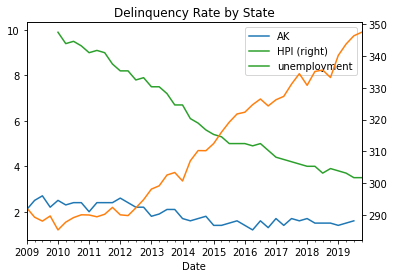

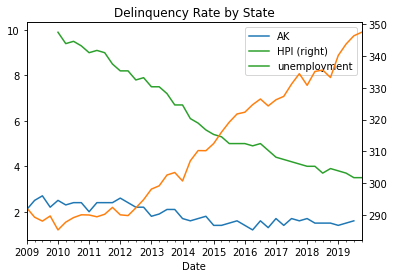

In [75]:
#change state for analysis
state = 'AK'
get_state_dq(state)
combined_df = get_state_dq(state)[2]
#question: why is the HPI color not orange for the legend?

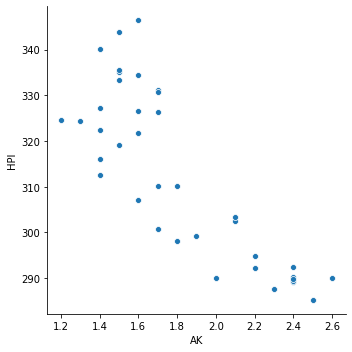

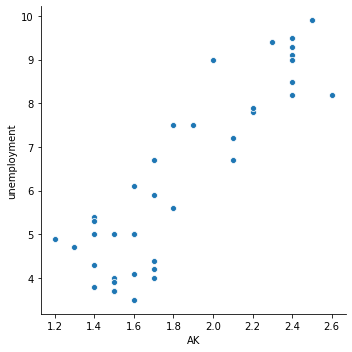

In [76]:
# get regression chart for delinquency and HPI by states
# sns.relplot(x='AK',y='HPI',data=get_state_dq('AK')[2])
# sns.relplot(x='AK',y='unemployment',data=get_state_dq('AK')[2])

sns.relplot(x=state,y='HPI',data=combined_df)
sns.relplot(x=state,y='unemployment',data = combined_df)


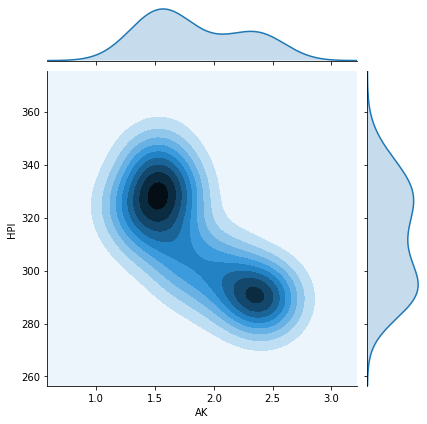

In [77]:
sns.jointplot(x=state,y='HPI',data=combined_df,kind='kde' )

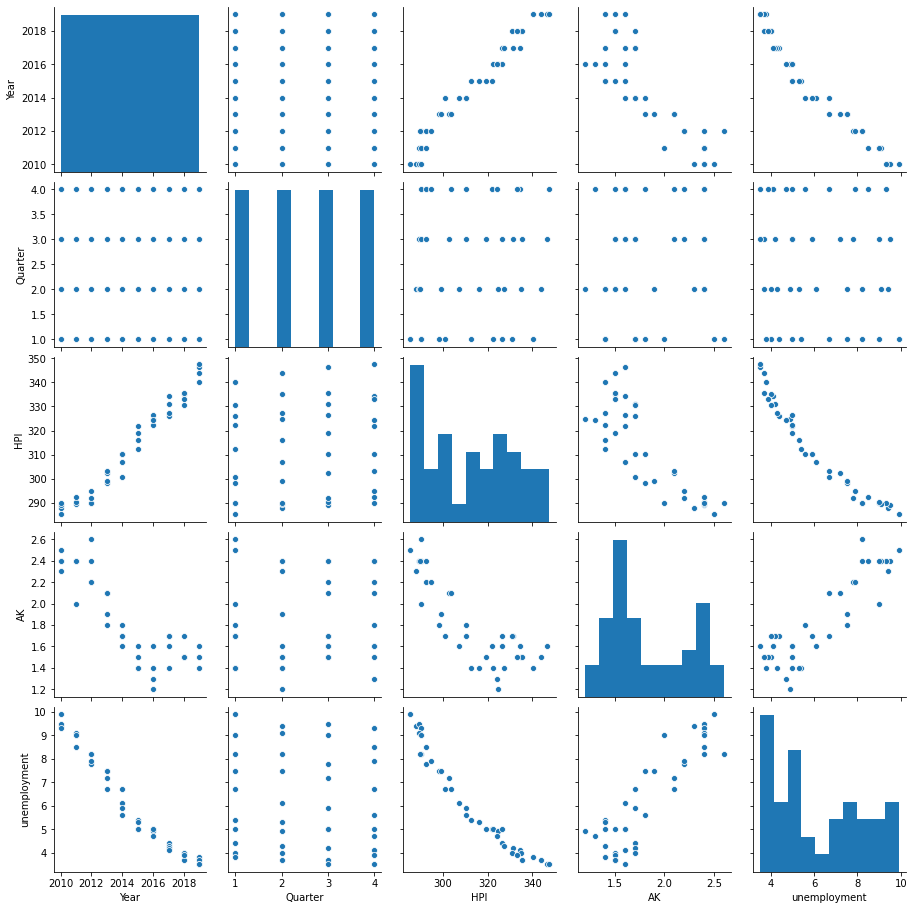

In [78]:
sns.pairplot(combined_df)

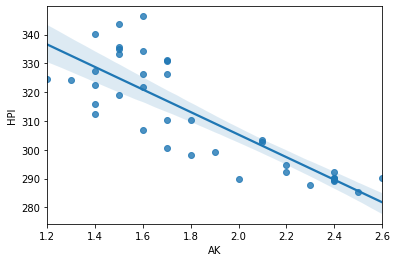

In [79]:
sns.regplot(x=state,y='HPI',data=combined_df)

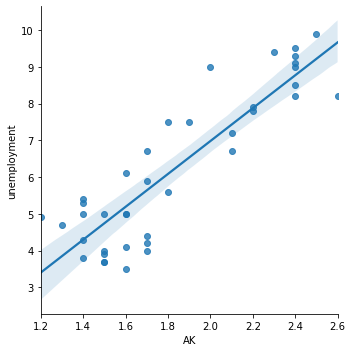

In [80]:
sns.lmplot(x=state,y='unemployment',data = combined_df, robust=True)

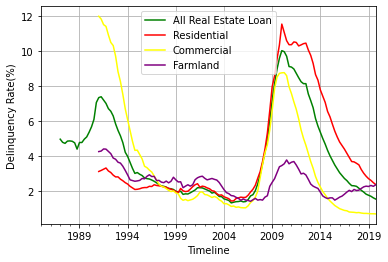

In [81]:
#converting multi line into a function
def plot_multi(asset_type):
  fig,ax = plt.subplots()
  for asset, color in asset_type:
    val = dq[asset]
    ax = dq[asset].plot(ax=ax,kind='line',x='Date',y=val,c=color,label = asset)
    plt.legend(loc='best')
  plt.xlabel('Timeline')
  plt.ylabel('Delinquency Rate(%)')
  plt.grid(True)
  plt.show()

plot_multi([('All Real Estate Loan','green'),('Residential','red'),('Commercial','yellow'),('Farmland','purple')])

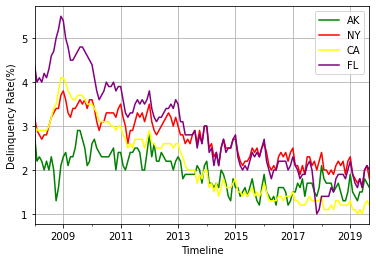

In [82]:
def plot_multi(asset_type,df):
  fig,ax = plt.subplots()
  for asset, color in asset_type:
    val = df[asset]
    ax = df[asset].plot(ax=ax,kind='line',x='Date',y=val,c=color,label = asset)
    plt.legend(loc='best')
  plt.xlabel('Timeline')
  plt.ylabel('Delinquency Rate(%)')
  plt.grid(True)
  plt.show()

plot_multi([('AK','green'),('NY','red'),('CA','yellow'),('FL','purple')],df=dqstate_30to89)

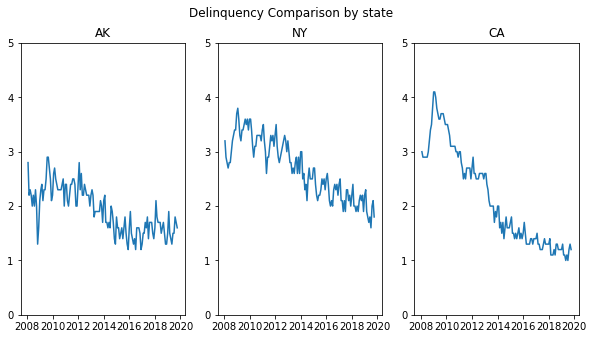

In [83]:
#comparing delinquency data with different state side by side
axs = (ax1,ax2,ax3)
fig,axs = plt.subplots(1,3,figsize=(10,5))
fig.suptitle('Delinquency Comparison by state')
states = ['AK','NY','CA']
for n,a in enumerate(axs):
  a.plot(dqstate_30to89.index,states[n],data=dqstate_30to89,label=states[n])
  a.set_ylim(0,5)
  a.set_title(states[n])

plt.show()

# **Conclusion**

1. Delinqunecy Rate is positively related the unemployment rate
2. Delinquency Rate is negatively correlated with HPI